In [4]:
#Model 0
from ultralytics import YOLO

model = YOLO('yolov8m-pose.pt')

results = model(source="img6.jpg", show=True, conf=0.3, save=True)

#model.train(data='coco8-pose.yaml', epochs=100, imgsz=640)

#metrics = model.val()  
#metrics.box.map    
#metrics.box.map50  
#metrics.box.map75  
#metrics.box.maps   



[W926 17:08:34.999299913 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


image 1/1 /home/pc/Desktop/RI_final/img6.jpg: 640x448 1 person, 5765.2ms
Speed: 21.0ms preprocess, 5765.2ms inference, 22.6ms postprocess per image at shape (1, 3, 640, 448)
Results saved to runs/pose/predict


In [4]:
#Model 1
import cv2 as cv
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [5]:
net = cv.dnn.readNetFromTensorflow('graph_opt.pb') #weights

In [6]:
inWidth = 368
inHeight = 368
thr = 0.2

In [7]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]


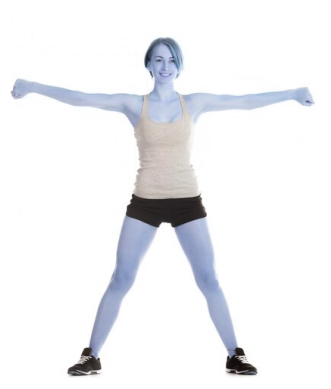

In [8]:
img = cv.imread("slika1.png")
plt.axis('off')
plt.imshow(img)

In [9]:
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5,127.5), swapRB = True, crop = False))
    out = net.forward()
    out = out[:, :19, :, :]
    
    assert(len(BODY_PARTS) == out.shape[1])
    
    points = []
    
    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]
        
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        points.append((int(x), int(y)) if conf > thr else None)
             
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)
             
        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        
        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3,3), 0, 0, 360, (0, 0, 255), cv.FILLED)
             
    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0))
    return frame

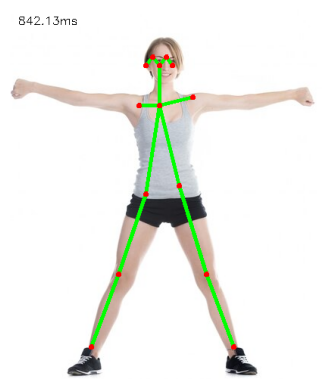

In [10]:
estimate_image = pose_estimation(img)
plt.axis('off')
plt.imshow(cv.cvtColor(estimate_image, cv.COLOR_BGRA2RGB))